In [1]:
#PreProcessing
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import joblib
import warnings
warnings.filterwarnings('ignore')
#Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier        # recommended for feature importance
from catboost import CatBoostClassifier  # optional alternative, handles categorical features natively
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap

In [2]:

df = pd.read_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/0_thyroid.csv')

# Pre-Processing

In [5]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,target
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,f,other,-
1,29,F,f,f,f,f,f,f,f,f,...,1.9,t,128.0,f,NaN,f,NaN,f,other,-
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,t,other,-
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,t,other,-
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,t,other,S


In [22]:
missing_values = df.isna().sum()
print(missing_values)

age                      0
sex                      0
on_thyroxine             0
query_on_thyroxine       0
on_antithyroid_meds      0
sick                     0
pregnant                 0
thyroid_surgery          0
I131_treatment           0
query_hypothyroid        0
query_hyperthyroid       0
lithium                  0
goitre                   0
tumor                    0
hypopituitary            0
psych                    0
TSH_measured             0
TSH                      0
T3_measured              0
T3                       0
TT4_measured             0
TT4                      0
T4U_measured             0
T4U                      0
FTI_measured             0
FTI                      0
TBG_measured             0
target                   0
referral_source_STMW     0
referral_source_SVHC     0
referral_source_SVHD     0
referral_source_SVI      0
referral_source_WEST     0
referral_source_other    0
dtype: int64


In [4]:
df.drop(columns=["TBG"], inplace=True)

In [5]:
for col in ["TSH","T3","TT4","T4U","FTI"]:
    df[col].fillna(df[col].median(), inplace=True)

In [6]:
df['sex'] = df['sex'].apply(lambda x: np.random.choice(df['sex'].dropna().unique()) if pd.isnull(x) else x)

In [7]:
missing_values = df.isna().sum()
print(missing_values)

age                    0
sex                    0
on_thyroxine           0
query_on_thyroxine     0
on_antithyroid_meds    0
sick                   0
pregnant               0
thyroid_surgery        0
I131_treatment         0
query_hypothyroid      0
query_hyperthyroid     0
lithium                0
goitre                 0
tumor                  0
hypopituitary          0
psych                  0
TSH_measured           0
TSH                    0
T3_measured            0
T3                     0
TT4_measured           0
TT4                    0
T4U_measured           0
T4U                    0
FTI_measured           0
FTI                    0
TBG_measured           0
referral_source        0
target                 0
dtype: int64


In [13]:
acceptable_max = {
    "age": 80,      
    "T3": 2.0,      
    "TT4": 200.0,   
    "T4U": 1.3,     
    "FTI": 200.0    
}
for col, max_val in acceptable_max.items():
    mean_val = df[col].mean()
    df[col] = df[col].apply(lambda x: mean_val if x > max_val else x)
for col in acceptable_max.keys():
    print(f"{col} -> max after cleaning: {df[col].max()}")

age -> max after cleaning: 80
T3 -> max after cleaning: 2.0
TT4 -> max after cleaning: 200.0
T4U -> max after cleaning: 1.3
FTI -> max after cleaning: 200.0


In [11]:
minmax_values = df.aggregate(['min','max'])
print(minmax_values)

     age sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick  \
min    1   F            f                  f                   f    f   
max   80   M            t                  t                   t    t   

    pregnant thyroid_surgery I131_treatment query_hypothyroid  ...    T3  \
min        f               f              f                 f  ...  0.05   
max        t               t              t                 t  ...  2.00   

    TT4_measured    TT4 T4U_measured   T4U FTI_measured    FTI  TBG_measured  \
min            f    2.0            f  0.17            f    1.4             f   
max            t  200.0            t  1.30            t  200.0             t   

    referral_source  target  
min            STMW       -  
max           other       S  

[2 rows x 29 columns]


In [12]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

age: [29 41 36 32 60 77 28 54 42 51 37 16 43 63 40 75 56 55 71 67 61 46 44 64
 70 33 59 53 52 49 35 48 27 69 76 73 68 66 30 38 58 21 45 62 25 72 14 15
 39 26 20 80 23 18 13 78 24 57 74  9 47 17 11 50 34  8 79 31 65 12 10 19
 22  1  2  6  7  5  4  3]
sex: ['F' 'M']
on_thyroxine: ['f' 't']
query_on_thyroxine: ['f' 't']
on_antithyroid_meds: ['f' 't']
sick: ['f' 't']
pregnant: ['f' 't']
thyroid_surgery: ['f' 't']
I131_treatment: ['f' 't']
query_hypothyroid: ['t' 'f']
query_hyperthyroid: ['f' 't']
lithium: ['f' 't']
goitre: ['f' 't']
tumor: ['f' 't']
hypopituitary: ['f' 't']
psych: ['f' 't']
TSH_measured: ['t' 'f']
TSH: [3.0000000e-01 1.6000000e+00 1.4000000e+00 7.0000000e-01 1.2000000e+00
 1.9000000e+00 1.0000000e+00 5.0000000e-01 2.6000000e+00 6.8000000e+01
 1.5000000e+00 5.9000000e+00 5.0000000e-02 4.0000000e+00 4.0000000e-01
 8.0000000e-01 2.0000000e-01 3.0000000e+00 9.5999990e+00 1.4000000e+02
 6.0000000e-01 1.7000000e+00 2.5000000e+00 6.8000000e+00 2.1000000e+00
 1.1000000e+00 9.79999

In [14]:
binary_cols = [
    "on_thyroxine", "query_on_thyroxine", "on_antithyroid_meds",
    "sick", "pregnant", "thyroid_surgery", "I131_treatment",
    "query_hypothyroid", "query_hyperthyroid", "lithium",
    "goitre", "tumor", "hypopituitary", "psych"
]
df[binary_cols] = df[binary_cols].replace({'f': 0, 't': 1})
print(df[binary_cols].head())

   on_thyroxine  query_on_thyroxine  on_antithyroid_meds  sick  pregnant  \
0             0                   0                    0     0         0   
1             0                   0                    0     0         0   
2             0                   0                    0     0         0   
3             0                   0                    0     0         0   
4             0                   0                    0     0         0   

   thyroid_surgery  I131_treatment  query_hypothyroid  query_hyperthyroid  \
0                0               0                  1                   0   
1                0               0                  0                   0   
2                0               0                  0                   1   
3                0               0                  0                   0   
4                0               0                  0                   0   

   lithium  goitre  tumor  hypopituitary  psych  
0        0       0      0     

In [15]:
sex_mapping = {"F": 0, "M": 1,}
df["sex"] = df["sex"].fillna("Unknown").map(sex_mapping)

In [16]:
ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False)
ref_source_encoded = ohe.fit_transform(df[["referral_source"]])
ref_source_encoded_df = pd.DataFrame(ref_source_encoded, 
                                     columns=ohe.get_feature_names_out(["referral_source"]))
df = pd.concat([df.drop(columns=["referral_source"]), ref_source_encoded_df], axis=1)

In [17]:
joblib.dump(ohe, "D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/referral_source_encoder_1.pkl")

['D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/referral_source_encoder_1.pkl']

In [18]:
df.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_encoded_1.csv', index=False)

In [19]:
df["target"] = df["target"].apply(lambda x: 0 if x == "-" else 1)
print(df["target"].value_counts())

target
0    6771
1    2401
Name: count, dtype: int64


In [20]:
measured_cols = [col for col in df.columns if "_measured" in col]
df[measured_cols] = df[measured_cols].replace({'t': 1, 'f': 0})
for col in measured_cols:
    print(f"{col}: {df[col].unique()}")

TSH_measured: [1 0]
T3_measured: [0 1]
TT4_measured: [0 1]
T4U_measured: [0 1]
FTI_measured: [0 1]
TBG_measured: [0 1]


In [21]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

age: [29 41 36 32 60 77 28 54 42 51 37 16 43 63 40 75 56 55 71 67 61 46 44 64
 70 33 59 53 52 49 35 48 27 69 76 73 68 66 30 38 58 21 45 62 25 72 14 15
 39 26 20 80 23 18 13 78 24 57 74  9 47 17 11 50 34  8 79 31 65 12 10 19
 22  1  2  6  7  5  4  3]
sex: [0 1]
on_thyroxine: [0 1]
query_on_thyroxine: [0 1]
on_antithyroid_meds: [0 1]
sick: [0 1]
pregnant: [0 1]
thyroid_surgery: [0 1]
I131_treatment: [0 1]
query_hypothyroid: [1 0]
query_hyperthyroid: [0 1]
lithium: [0 1]
goitre: [0 1]
tumor: [0 1]
hypopituitary: [0 1]
psych: [0 1]
TSH_measured: [1 0]
TSH: [3.0000000e-01 1.6000000e+00 1.4000000e+00 7.0000000e-01 1.2000000e+00
 1.9000000e+00 1.0000000e+00 5.0000000e-01 2.6000000e+00 6.8000000e+01
 1.5000000e+00 5.9000000e+00 5.0000000e-02 4.0000000e+00 4.0000000e-01
 8.0000000e-01 2.0000000e-01 3.0000000e+00 9.5999990e+00 1.4000000e+02
 6.0000000e-01 1.7000000e+00 2.5000000e+00 6.8000000e+00 2.1000000e+00
 1.1000000e+00 9.7999990e+00 3.7000000e+00 1.0000000e-01 3.5000000e-01
 9.0000000e+01 

In [23]:
df.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_encoded_2.csv', index=False)

### Scaling

In [24]:
scaler = MinMaxScaler()

In [25]:
numeric_features = df.select_dtypes(include=['int64','float64']).columns
non_binary_numeric = [col for col in numeric_features if df[col].nunique() > 2]

In [26]:
df[non_binary_numeric] = scaler.fit_transform(df[non_binary_numeric])

In [27]:
joblib.dump(scaler, "D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/minmax_scaler_1.pkl")

['D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/minmax_scaler_1.pkl']

In [28]:
df_scaled = df.copy()

In [29]:
df_scaled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,FTI_measured,FTI,TBG_measured,target,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_WEST,referral_source_other
0,0.354430,0,0,0,0,0,0,0,0,1,...,0,0.541793,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.354430,0,0,0,0,0,0,0,0,0,...,0,0.541793,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.506329,0,0,0,0,0,0,0,0,0,...,0,0.541793,1,0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.443038,0,0,0,0,0,0,0,0,0,...,0,0.541793,1,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.392405,0,0,0,0,0,0,0,0,0,...,0,0.541793,1,1,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
#df_scaled = df_scaled.astype({col: int for col in df_scaled.columns})

In [30]:
df_scaled.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_scaled_1.csv', index=False)

### Imbalance Learning

In [31]:
X = df_scaled.drop(columns=['target'], axis = 1)
y = df_scaled['target']  

In [32]:
print(y.value_counts()) 

target
0    6771
1    2401
Name: count, dtype: int64


In [34]:
adasyn = ADASYN(random_state=42, sampling_strategy='auto')
X_res, y_res = adasyn.fit_resample(X, y)

In [35]:
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['target'] = y_res

In [36]:
df_resampled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,FTI_measured,FTI,TBG_measured,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_WEST,referral_source_other,target
0,0.354430,0,0,0,0,0,0,0,0,1,...,0,0.541793,0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.354430,0,0,0,0,0,0,0,0,0,...,0,0.541793,0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,0.506329,0,0,0,0,0,0,0,0,0,...,0,0.541793,1,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.443038,0,0,0,0,0,0,0,0,0,...,0,0.541793,1,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.392405,0,0,0,0,0,0,0,0,0,...,0,0.541793,1,0.0,0.0,0.0,0.0,0.0,1.0,1


In [37]:
df_resampled.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_resampled.csv', index=False)

### Feature Engineering

In [38]:
X_fe = df_resampled.drop(columns=['target'])
y_fe = df_resampled['target']

In [39]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_fe, y_fe)

RandomForestClassifier(random_state=42)

In [40]:
feature_importance = pd.DataFrame({
    'feature': X_fe.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

In [41]:
print(feature_importance)

                  feature  importance
17                    TSH    0.294874
21                    TT4    0.157131
25                    FTI    0.139620
19                     T3    0.127404
0                     age    0.081491
23                    T4U    0.080356
1                     sex    0.012305
18            T3_measured    0.010035
2            on_thyroxine    0.009791
32  referral_source_other    0.008601
10     query_hyperthyroid    0.006998
30    referral_source_SVI    0.006828
27   referral_source_STMW    0.006180
16           TSH_measured    0.006008
26           TBG_measured    0.005991
9       query_hypothyroid    0.005023
13                  tumor    0.004643
28   referral_source_SVHC    0.004543
6                pregnant    0.004417
5                    sick    0.003333
15                  psych    0.003093
24           FTI_measured    0.002623
7         thyroid_surgery    0.002569
22           T4U_measured    0.002537
4     on_antithyroid_meds    0.002473
8          I

In [42]:
importance_df = pd.DataFrame({
    'Feature': X_fe.columns,
    'Importance': rf.feature_importances_
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

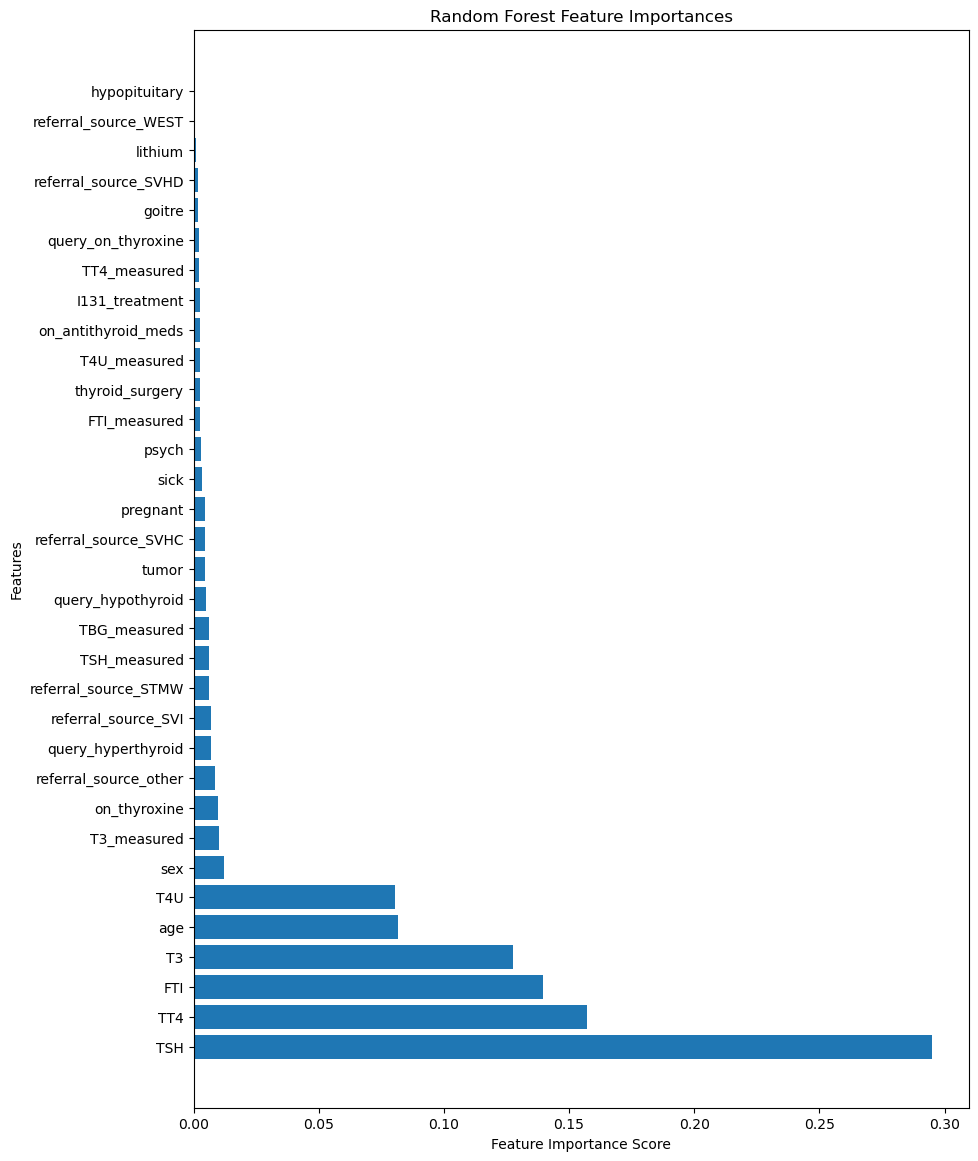

In [43]:
plt.figure(figsize=(10, 14))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances")
plt.show()

In [44]:
drop_columns = [
    # referral sources
    "referral_source_other", "referral_source_STMW", "referral_source_SVI",
    "referral_source_SVHC", "referral_source_SVHD", "referral_source_WEST",
    
    # measurement flags
    "TBG_measured", "TT4_measured", "T4U_measured", 
    "FTI_measured", "TSH_measured", "T3_measured",
    
    # rare conditions
    "lithium", "hypopituitary"
]

In [55]:
df_cleaned = df_resampled.drop(columns=[col for col in drop_columns if col in df_resampled.columns])
print("Remaining columns after drop:", df_cleaned.columns.tolist())

Remaining columns after drop: ['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'goitre', 'tumor', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']


In [56]:
df_cleaned.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,goitre,tumor,psych,TSH,T3,TT4,T4U,FTI,target
0,0.354430,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000557,0.948718,0.515152,0.699115,0.541793,0
1,0.354430,0,0,0,0,0,0,0,0,0,0,0,0,0,0.003009,0.948718,0.636364,0.699115,0.541793,0
2,0.506329,0,0,0,0,0,0,0,0,0,1,0,0,0,0.002632,0.948718,0.515152,0.699115,0.541793,0
3,0.443038,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002632,0.948718,0.515152,0.699115,0.541793,0
4,0.392405,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002632,0.948718,0.515152,0.699115,0.541793,1


In [57]:
df_cleaned.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_final.csv', index=False)

### Feature selection on Pre Df

In [49]:
df_pre = pd.read_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/1_thyroid_pre.csv')

In [50]:
X_pre = df_pre.drop(columns=['target'])
y_pre = df_pre['target']

In [51]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_pre, y_pre)

RandomForestClassifier(random_state=42)

In [52]:
feature_importance_pre = pd.DataFrame({
    'feature': X_pre.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

In [53]:
print(feature_importance_pre)

                  feature  importance
17                    TSH    0.278705
19                     T3    0.161358
25                    FTI    0.157141
21                    TT4    0.154132
23                    T4U    0.073615
0                     age    0.062399
6                pregnant    0.010397
32  referral_source_other    0.010233
2            on_thyroxine    0.010097
18            T3_measured    0.008633
27   referral_source_STMW    0.008331
1                     sex    0.008093
30    referral_source_SVI    0.007540
10     query_hyperthyroid    0.005629
16           TSH_measured    0.004593
13                  tumor    0.004433
28   referral_source_SVHC    0.004326
9       query_hypothyroid    0.004299
26           TBG_measured    0.003170
5                    sick    0.002979
7         thyroid_surgery    0.002858
4     on_antithyroid_meds    0.002402
22           T4U_measured    0.002136
24           FTI_measured    0.002104
8          I131_treatment    0.002014
3      query

In [54]:
importance_df_pre = pd.DataFrame({
    'Feature': X_fe.columns,
    'Importance': rf.feature_importances_
})
importance_df_pre = importance_df_pre.sort_values(by='Importance', ascending=False)

In [58]:
# Columns identified as very low importance / noisy
drop_columns = [
    # referral sources
    "referral_source_other", "referral_source_STMW", "referral_source_SVI",
    "referral_source_SVHC", "referral_source_SVHD", "referral_source_WEST",
    
    # measured flags
    "T3_measured", "TSH_measured", "TT4_measured", 
    "T4U_measured", "FTI_measured", "TBG_measured",
    
    # very low importance / rare
    "sick", "psych", "lithium", "hypopituitary"
]

# Drop them safely (ignore if not present in df)
df_cleaned = df_pre.drop(columns=[col for col in drop_columns if col in df_pre.columns])

print("Remaining columns after drop:", df_cleaned.columns.tolist())


Remaining columns after drop: ['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'goitre', 'tumor', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']


In [59]:
df_cleaned.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_final_pre.csv', index=False)